<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Import-modules,-data,-set-constants,-define-convenience-functions" data-toc-modified-id="Import-modules,-data,-set-constants,-define-convenience-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import modules, data, set constants, define convenience functions</a></span><ul class="toc-item"><li><span><a href="#Data-load-and-train-test-split" data-toc-modified-id="Data-load-and-train-test-split-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data load and train test split</a></span></li><li><span><a href="#Test-sample-evaluation-function" data-toc-modified-id="Test-sample-evaluation-function-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Test sample evaluation function</a></span></li><li><span><a href="#State-the-hyperparameters" data-toc-modified-id="State-the-hyperparameters-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>State the hyperparameters</a></span></li></ul></li><li><span><a href="#Multinomial-regression" data-toc-modified-id="Multinomial-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Multinomial regression</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Naive-Bayes-Classification" data-toc-modified-id="Naive-Bayes-Classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Naive Bayes Classification</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Train-and-save-the-finalised-models-(trained-on-the-whole-dataset)" data-toc-modified-id="Train-and-save-the-finalised-models-(trained-on-the-whole-dataset)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train and save the finalised models (trained on the whole dataset)</a></span></li></ul></div>

## Intro

In this notebook you will see how good at predictions the models in the repo are. Here we split the full pre-processed dataset into the **train** ant **test** samples and train the models all over again on the train sample exclusively. This notebook has demonstration purpose only. The actual models stored in the repo are trained on **the full dataset**.

Here we *DO NOT*:
- Fine tune the hyperparameters (we did it beforehand)
- We do not clean and preprocess the data (we did it beforehand and believe that we'd found the best pipeline for processing)
- Evaluate the finalized model

## Import modules, data, set constants, define convenience functions

In [1]:
from pathlib import Path
import joblib
from zipfile import ZipFile

import pandas as pd
import numpy as np



from sklearn.metrics import (balanced_accuracy_score,
                             accuracy_score,f1_score,
                             precision_score,recall_score,
                             confusion_matrix,ConfusionMatrixDisplay)

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt


RANDOM_STATE = 12345
np.random.seed(RANDOM_STATE)

### Data load and train test split

In [2]:
df = pd.read_csv(Path.cwd().joinpath("data","clean_data_wo_frequency.csv.zip"), compression='zip')

# We treat Komi Permyak and Komi Zyrian as one language "Komi"
df.language = df.language.str.replace(r"(?<=Komi)_.+$", "",regex=True)
print(df.language.unique())



['Abaza' 'Yakut' 'Moksha' 'Komi' 'Kyrgyz' 'Kazakh' 'Erzya' 'Buryat'
 'Ukrainian' 'Russian' 'Belarusian']


In [3]:
# classes balance in the dataset
distribution = df.rename(columns={'token_id':'tokens'}).groupby('language', as_index=False).count()
distribution['ratio'] = round(distribution.lemma/distribution.lemma.sum(),4)
distribution[['language','ratio','tokens']].sort_values(by='ratio',ascending=False)

,language,ratio,tokens
8,Russian,0.7467,619668
1,Belarusian,0.1276,105935
9,Ukrainian,0.0757,62829
3,Erzya,0.0144,11963
5,Komi,0.0091,7571
4,Kazakh,0.0076,6341
2,Buryat,0.0075,6244
6,Kyrgyz,0.0057,4708
7,Moksha,0.0033,2780
0,Abaza,0.0012,1014


In [4]:
X,y = df.word, df.language
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    test_size=.2,
                                                   stratify=y)

print(X_train.shape, y_train.shape,X_test.shape,y_test.shape)

(663934,) (663934,) (165984,) (165984,)


### Test sample evaluation function

In [5]:
def testing(estimator, X_test, y_test):
    
    '''TEST THE ESTIMATOR (WITHIN PIPELINE) ON THE TEST SAMPLE AND
    RETURN CONFUSION MATRIX, MISTAKEN PREDICTIONS, CLASSES QUANTITY IN THE TEST SAMPLE'''
    
    # matrix
    
    if isinstance(estimator,Pipeline):
        preds = estimator.predict(X_test)
        class_labels = estimator.classes_
        class_name = estimator[-1].__class__.__name__

    
    fig, ax = plt.subplots(figsize=(20, 10))
    ConfusionMatrixDisplay.from_predictions(y_test, preds, ax=ax, 
                                            normalize='true',
                                            xticks_rotation='vertical',
                                           values_format=".3f")
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)

    _ = ax.set_title(
    f"Confusion Matrix for {class_name}\non the test sample")
    
    
    fig.savefig(str(class_name)+'_test_confusion_matrix.png', bbox_inches='tight')
    
    ## metrics
    accuracy = accuracy_score(y_true=y_test, y_pred=preds)
    balanced_accuracy = balanced_accuracy_score(y_true=y_test, y_pred=preds)
    
    precision = precision_score(y_true=y_test, y_pred=preds, average="weighted")
    recall = recall_score(y_true=y_test, y_pred=preds, average="weighted")
    f1 = f1_score(y_true=y_test, y_pred=preds, average="weighted")
    
    
    ## false predictions table
    mistakes_table = pd.DataFrame(
        {'test_words': X_test,
              'real': y_test, 
              'preds': preds})
    mistakes_table['mistake'] = mistakes_table['real'] != mistakes_table['preds']
    mistakes_table = mistakes_table[mistakes_table.mistake == True].drop('mistake',axis=1)

    #mistakes_table.to_csv(str(class_name)+'_test_mistakes_table.csv',index=False,index_label=False,mode='w')
    
    ## display 
    print("ACCURACY_SCORE\n",accuracy)
    print("BALANCED_ACCURACY_SCORE\n",balanced_accuracy)
    
    print("WEIGHTED_PRECISION_SCORE\n",precision)
    print("precision is: TP / (TP + FP) \n")
    print("WEIGHTED_RECALL_SCORE\n",recall)
    print("recall is: TP / (TP + FN) \n")
    print("WEIGHTED_F1_SCORE\n",f1)
    print("F1 is: 2 * (precision * recall) / (precision + recall)\n")

    
    print("CLASSES IN THE TEST SAMPLE")
    display(y_test.value_counts())
    
    #print("FALSE PREDICTIONS\n")
    #display(mistakes_table)
    

### State the hyperparameters

The hyperparameters were finetuned beforehand

In [6]:
# Count vectorizer params, e.g. how to make a bag of words
log_reg_vectorizer_params = {"analyzer":'char_wb',"ngram_range":(1,4),"binary":False,"encoding":'utf-8',
                    "lowercase": True, "max_df":1.0, "max_features": None, "strip_accents":None,
                    "token_pattern": '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}

logreg_params = {"C":.5,"max_iter":10000000000, "multi_class":'multinomial',"n_jobs":-1,
                "random_state":12345,"solver":"newton-cg","fit_intercept":True,"penalty":'l2','warm_start': False}


bayes_vectorizer_params = {"analyzer":'char_wb',"ngram_range":(1,6),"binary":False,"encoding":'utf-8',
                    "lowercase": True, "max_df":1.0, "max_features": None, "strip_accents":None,
                    "token_pattern": '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}


bayes_params = {'alpha': 1e-06,'class_prior': None,'fit_prior': True,'force_alpha': True}


## Multinomial regression
### Training

In [7]:
%%time
logreg_pipe = Pipeline([('vectorizer',CountVectorizer(**log_reg_vectorizer_params)),
                       ('estimator',LogisticRegression(**logreg_params))])
fitted_logreg_pipe = logreg_pipe.fit(X_train,y_train)
print("It was trained on my machine within this time")

It was trained on my machine within this time
CPU times: user 21.7 s, sys: 1.58 s, total: 23.2 s
Wall time: 29min 53s


### Testing

ACCURACY_SCORE
 0.9536883073067284
BALANCED_ACCURACY_SCORE
 0.8083685734132202
WEIGHTED_PRECISION_SCORE
 0.9530631258675172
precision is: TP / (TP + FP) 

WEIGHTED_RECALL_SCORE
 0.9536883073067284
recall is: TP / (TP + FN) 

WEIGHTED_F1_SCORE
 0.9519509054079436
F1 is: 2 * (precision * recall) / (precision + recall)

CLASSES IN THE TEST SAMPLE


language
Russian       123934
Belarusian     21187
Ukrainian      12566
Erzya           2393
Komi            1514
Kazakh          1268
Buryat          1249
Kyrgyz           941
Moksha           556
Abaza            203
Yakut            173
Name: count, dtype: int64

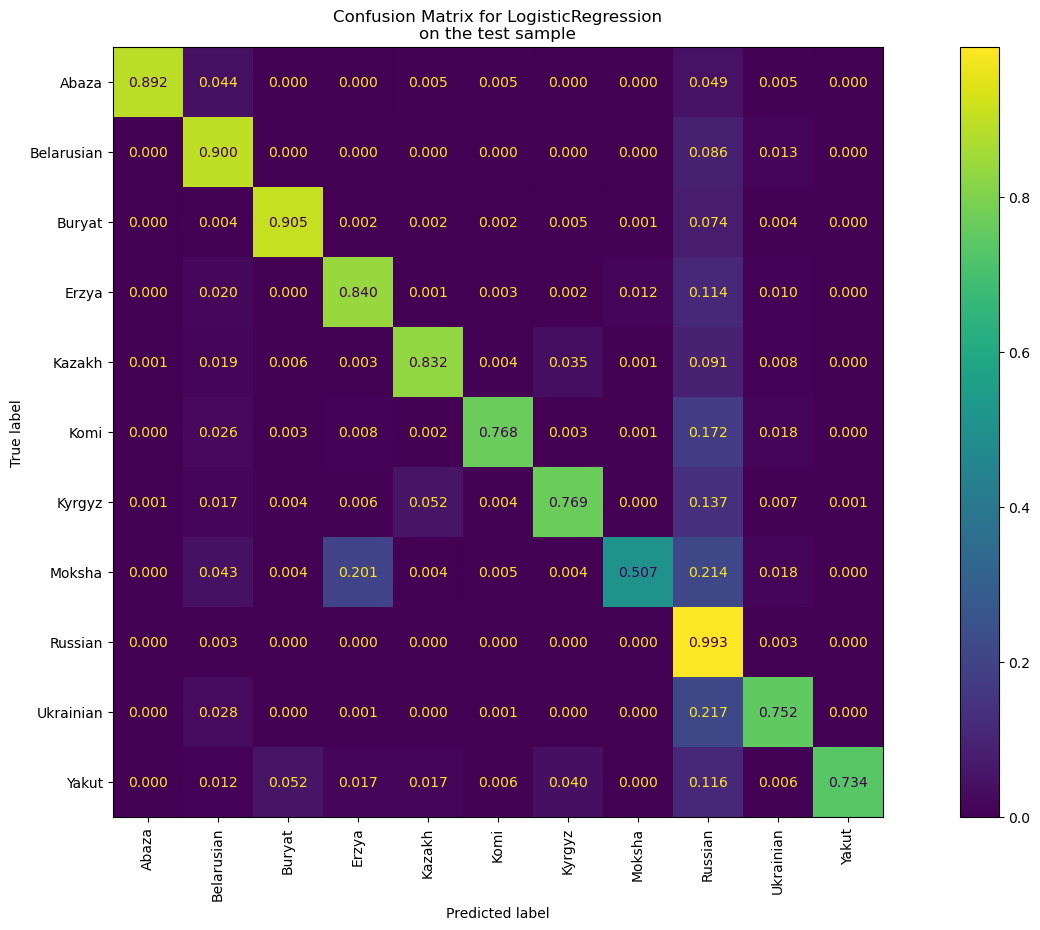

In [8]:
testing(fitted_logreg_pipe,X_test,y_test)

## Naive Bayes Classification
### Training

In [9]:
%%time
bayes_pipe = Pipeline([('vectorizer',CountVectorizer(**bayes_vectorizer_params)),
                       ('estimator',MultinomialNB(**bayes_params))])
fitted_bayes_pipe = bayes_pipe.fit(X_train,y_train)
print("It was trained on my machine within this time")

It was trained on my machine within this time
CPU times: user 28.6 s, sys: 1.1 s, total: 29.7 s
Wall time: 29.8 s


### Testing

ACCURACY_SCORE
 0.9177330345093503
BALANCED_ACCURACY_SCORE
 0.8628314121441982
WEIGHTED_PRECISION_SCORE
 0.9274380487234538
precision is: TP / (TP + FP) 

WEIGHTED_RECALL_SCORE
 0.9177330345093503
recall is: TP / (TP + FN) 

WEIGHTED_F1_SCORE
 0.9208546288848986
F1 is: 2 * (precision * recall) / (precision + recall)

CLASSES IN THE TEST SAMPLE


language
Russian       123934
Belarusian     21187
Ukrainian      12566
Erzya           2393
Komi            1514
Kazakh          1268
Buryat          1249
Kyrgyz           941
Moksha           556
Abaza            203
Yakut            173
Name: count, dtype: int64

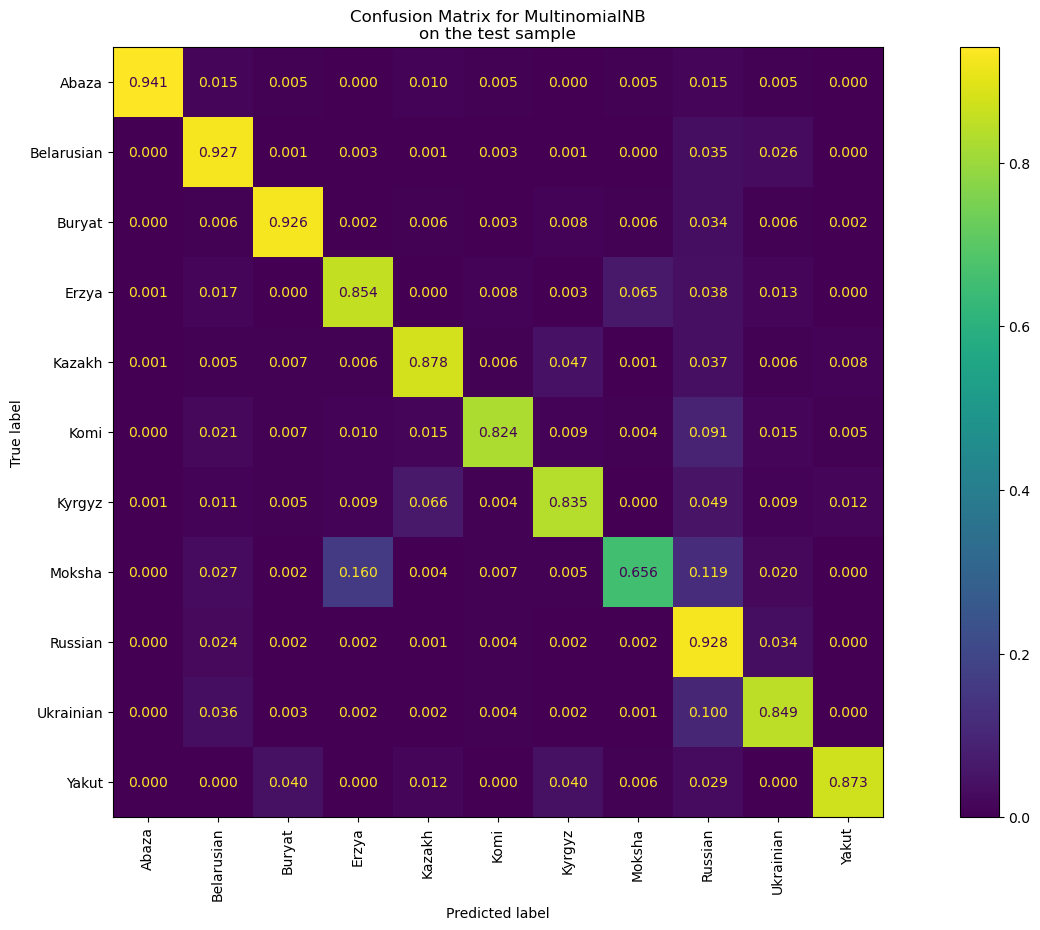

In [10]:
testing(fitted_bayes_pipe, X_test, y_test)

## Train and save the finalised models (trained on the whole dataset)

In [11]:
joblib.dump(logreg_pipe.fit(X,y), "models/logreg_model.pickle")

['models/logreg_model.pickle']

In [12]:
joblib.dump(bayes_pipe.fit(X,y), "models/bayes_model.pickle", compress=1)


['models/bayes_model.pickle']